In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from translation import translate_df

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
file_path = 'C:/Users/Jacob/Documents/datasets/amsterdamumcdb-1.0.2/'
save_path = 'C:/Users/Jacob/Documents/datasets/amsterdamumcdb-1.0.2-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
adm = pd.read_csv(os.path.join(save_path, 'admissions.csv'))
# adm, adm_dict = translate_df(adm)
adm.head()

,Unnamed: 0,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,...,destination,gender,agegroup,dateofdeath,weightgroup,weightsource,heightgroup,heightsource,specialty,icudeath
0,4,4,4,1,IC&MC,0,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,180900000,...,19,Man,70-79,NaN,70-79,Anamnestisch,170-179,Anamnestisch,Cardiochirurgie,False
1,5,5,5,1,IC,1,Eerste Hulp afdeling zelfde ziekenhuis,0,2010-2016,246420000,...,31,Man,50-59,NaN,60-69,Geschat,160-169,Gemeten,Longziekte,False
2,9,9,9,1,IC,0,NaN,0,2003-2009,242040000,...,15,Vrouw,70-79,NaN,70-79,NaN,159-,NaN,Cardiochirurgie,False
3,12,12,12,1,IC,0,NaN,0,2003-2009,627960000,...,29,Man,18-39,NaN,90-99,NaN,NaN,NaN,NaN,False
4,15,14,15,1,IC,1,Eerste Hulp afdeling zelfde ziekenhuis,0,2010-2016,893220000,...,Overleden,Man,60-69,812280000.0,60-69,Geschat,160-169,Geschat,Cardiologie,True


## Free text items data

In [5]:
fti_cols = ['admissionid', 'itemid', 'item', 'value', 'comment', 'measuredat', 'updatedat']
fti = pd.read_csv(os.path.join(file_path, "freetextitems.csv"), encoding='latin-1', usecols=fti_cols)
print(fti.shape)
fti = fti.loc[fti["admissionid"].isin(adm["admissionid"])]
print(fti.shape)
# fti, fti_dict = translate_df(fti)
fti.head()

(651248, 7)
(222015, 7)


,admissionid,itemid,item,value,comment,measuredat,updatedat
53,4,10890,Eiwit Kwal (urine),Negatief,NaN,-256020000,143296
54,4,10891,Gluc.Kwal. (urine),Negatief,NaN,-256020000,142730
55,4,10906,Hb/Ery's (urine),Negatief,NaN,-256020000,143476
56,4,10948,spijt (bloed),opgeslagen,Buizen achtergelaten voor afname door arts,-260400000,151046
57,4,11646,Afname (bloed),Art.,NaN,-15960000,138070


In [6]:
# For now, everythign is a lab result, so ignore this

# Just keep lab results?
# fti = fti.loc[fti["islabresult"] == 1]
# fti.shape

In [8]:
fti = fti.loc[0 < fti["measuredat"]]
print(fti.shape)
fti["measuredat"] = fti["measuredat"] / 1000 / 3600 / 24
fti["updatedat"] = fti["updatedat"] / 1000 / 3600 / 24
fti.head()

(191864, 7)


,admissionid,itemid,item,value,comment,measuredat,updatedat
61,4,11646,Afname (bloed),Art.,NaN,4.822531e-11,0.962064
62,4,11646,Afname (bloed),Art.,NaN,8.278678e-10,0.962080
63,4,11646,Afname (bloed),Gem. ven.,NaN,1.454797e-09,0.132599
64,4,11646,Afname (bloed),Art.,NaN,1.969200e-09,0.176211
65,4,11646,Afname (bloed),Art.,NaN,3.335584e-09,0.293870


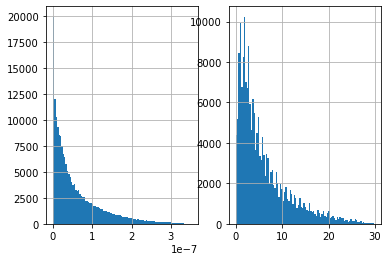

In [9]:
# `updatedat` does not appear to be consisten with `measuredat` (see rows above) and also contains extreme upper-bound outliers
plt.figure()
plt.subplot(1, 2, 1)
fti["measuredat"].hist(bins=100)
plt.subplot(1, 2, 2)
fti["updatedat"].loc[fti["updatedat"] < 50].hist(bins=100)

In [10]:
fti = pd.merge(fti, adm[["admissionid", "lengthofstay"]], on="admissionid")
fti.head()

,admissionid,itemid,item,value,comment,measuredat,updatedat,lengthofstay
0,4,11646,Afname (bloed),Art.,NaN,4.822531e-11,0.962064,2.083333
1,4,11646,Afname (bloed),Art.,NaN,8.278678e-10,0.962080,2.083333
2,4,11646,Afname (bloed),Gem. ven.,NaN,1.454797e-09,0.132599,2.083333
3,4,11646,Afname (bloed),Art.,NaN,1.969200e-09,0.176211,2.083333
4,4,11646,Afname (bloed),Art.,NaN,3.335584e-09,0.293870,2.083333


In [11]:
fti = fti.loc[fti["measuredat"] < fti["lengthofstay"]]
fti.shape

(191864, 8)

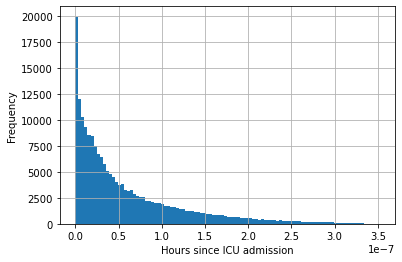

In [12]:
_ = fti["measuredat"].hist(bins=100)
_ = plt.xlabel("Hours since ICU admission"), plt.ylabel("Frequency")

In [13]:
fti["item"].value_counts(dropna=False)

Afname (bloed)                     174801
Spijt Bew. (bloed)                   1329
Grootte (bloed)                      1020
Kleur (bloed)                         873
Ery's (urine)                         554
                                    ...  
M. genus DNA PCR (pleurapunct.)         1
HSV type 1 DNA PCR (pus)                1
BLOEDGR.3e (bloed)                      1
Echinococcus granulosus (bloed)         1
Helicobacter pylori Ag (faeces)         1
Name: item, Length: 616, dtype: int64

In [14]:
# Keep 20 most frequent free text values
fti = fti.loc[fti["value"].isin(fti["value"].value_counts().index.to_list()[:20])]
print(fti.shape)
fti["value"].value_counts(dropna=False)

(188579, 8)


Art.                 87882
ART.                 79225
Negatief              4357
volgt                 3100
Ven.                  1995
GEM.VEN.              1991
ANISO+                1417
Inhoud verwijderd     1358
Gem. ven.             1337
+                     1035
VEN.                   813
ZIE-OPM                645
Positief               550
Vervalt                463
+++                    452
Verzond.               448
WEINIG                 437
NEGATIEF               411
++                     336
Veel                   327
Name: value, dtype: int64

In [15]:
# # Keep 10 most frequent free text comments
# fti = fti.loc[fti["comment"].isin(fti["comment"].value_counts().index.to_list()[:10])]
# print(fti.shape)
fti["comment"].value_counts(dropna=False)

NaN                                              183884
Afn. uit arterielijn door afdeling                 1309
Opmerking verwijderd                                583
Afname uit arterielijn door afdeling                267
Vraagstelling: dysmorfe erys?                       198
                                                  ...  
virussen.`Niet te beoordelen                          1
Verdenking ontsteking tongbasis.                      1
incl. glucose                                         1
lab07-T=6uur                                          1
HSV - Herpes simplex virus type 1 geisoleerd.         1
Name: comment, Length: 977, dtype: int64

In [16]:
fti.to_csv(os.path.join(save_path, "freetextitems.csv"))